In [1]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 2060 (UUID: GPU-380040ef-0399-d9a4-9c93-391f6718fa1c)


In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
GPU_ID = "GPU-380040ef-0399-d9a4-9c93-391f6718fa1c"
IMG_SIZE = 100
BATCH_SIZE= 10

In [4]:
import os
import json
import matplotlib.pyplot as plt
import random
import numpy as np
import cv2 as cv
from keras.preprocessing.image import ImageDataGenerator

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = GPU_ID

In [6]:
with open(os.path.join('..','config.json'),'r')as f:
    x=json.load(f)
x

{'0': 'aviral',
 '1': 'gagan',
 '2': 'himanshu',
 '3': 'muskaan',
 '4': 'rishu',
 '5': 'shashank',
 '6': 'vijit',
 '7': 'aryan',
 '8': 'kanika',
 '9': 'rishika',
 '10': 'tanishka',
 '11': 'riya',
 '12': 'prabhat'}

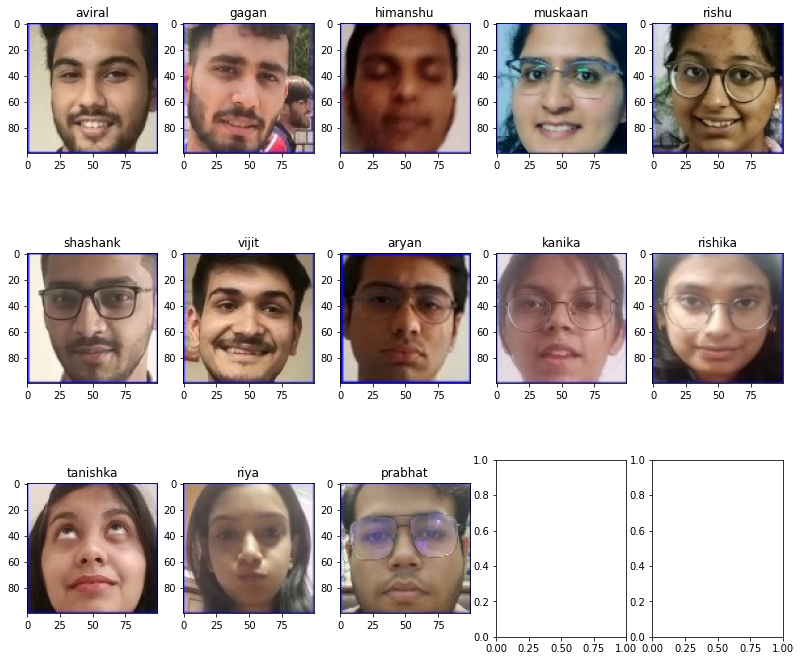

In [14]:
figure, axis = plt.subplots(3, 5,figsize=(15,15))
k=0
ind=[random.randint(0,801) for i in range(13)]
for i in range(3):
    for j in range(5):
        frame = cv.imread(os.path.join('..','dataset','train',str(k),str(ind[k])+'.jpg'))
        frame=cv.cvtColor(frame,cv.COLOR_RGB2BGR)
        axis[i,j].imshow(frame)
        axis[i,j].set_title(x[str(k)])
        k+=1
        if k==13:
            break
plt.subplots_adjust(left=0.2,
                    bottom=0.01, 
                    right=0.9, 
                    top=0.6, 
                    wspace=0.2, 
                    hspace=0.3)
plt.show()


In [15]:
img_gen = ImageDataGenerator(rescale=1./255,zoom_range=0.5,validation_split=0.2,shear_range=0.5)

In [16]:
train_data = img_gen.flow_from_directory(os.path.join('..','dataset','train'),
                                                 target_size=(IMG_SIZE, IMG_SIZE),
                                                 batch_size=BATCH_SIZE,
                                                #  color_mode='grayscale',
                                                 class_mode='categorical',
                                                 subset='training',
                                                 shuffle=True)

validation_data = img_gen.flow_from_directory(os.path.join('..','dataset','train'),
                                                 target_size=(IMG_SIZE, IMG_SIZE),
                                                 batch_size=BATCH_SIZE,
                                                #  color_mode='grayscale',
                                                 class_mode='categorical',
                                                 subset='validation',
                                                 shuffle=True)

Found 8930 images belonging to 13 classes.
Found 2232 images belonging to 13 classes.


In [17]:
os.mkdir(os.path.join('..','model'))
label_map = train_data.class_indices
with open(os.path.join("..", "model", "class indices"), 'w') as f:
    json.dump(label_map, f, indent=2)
print("done")

done


In [18]:
test_data = img_gen.flow_from_directory(os.path.join('..','dataset','test'),
                                            target_size=(IMG_SIZE , IMG_SIZE),
                                            batch_size=BATCH_SIZE,
                                            # color_mode='grayscale',
                                            class_mode='categorical',
                                            shuffle=True) 

Found 1856 images belonging to 13 classes.


In [19]:
from keras.models import Sequential
from keras.layers import Convolution2D,MaxPooling2D,Flatten,Dense ,LeakyReLU

In [38]:
classifier = Sequential()


In [39]:
classifier.add(Convolution2D(64, kernel_size=(3,3),activation='linear',input_shape=(100,100,3),padding='same'))


In [40]:
classifier.add(LeakyReLU(alpha=0.3))


In [41]:
classifier.add(MaxPooling2D((2, 2),padding='same'))


In [42]:
classifier.add(Convolution2D(128, (3, 3), activation='linear',padding='same'))


In [43]:
classifier.add(LeakyReLU(alpha=0.1))


In [44]:
classifier.add(MaxPooling2D(pool_size=(2, 2),padding='same'))


In [45]:
classifier.add(Convolution2D(16, (3, 3), activation='linear',padding='same'))


In [46]:
classifier.add(LeakyReLU(alpha=0.5))                  


In [47]:
classifier.add(MaxPooling2D(pool_size=(2, 2),padding='same'))


In [48]:
classifier.add(Flatten())


In [49]:
classifier.add(Dense(4, activation='linear'))

In [50]:
classifier.add(LeakyReLU(alpha=0.1))                

In [51]:
classifier.add(Dense(13, activation='softmax'))

In [52]:
classifier.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])


In [53]:
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 100, 100, 64)      1792      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 100, 100, 64)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 50, 50, 128)       0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 25, 25, 128)      0         
 2D)                                                  

In [54]:
history = classifier.fit(
        train_data,
        epochs=2,
        validation_data=validation_data)

Epoch 1/2
893/893 [==============================] - 55s 61ms/step - loss: 0.8992 - accuracy: 0.6953 - val_loss: 0.3120 - val_accuracy: 0.9010
Epoch 2/2
893/893 [==============================] - 25s 28ms/step - loss: 0.2159 - accuracy: 0.9378 - val_loss: 0.1122 - val_accuracy: 0.9731


In [55]:
scores =classifier.evaluate(test_data, verbose=0)

In [56]:
print("%s: %.2f%%" % (classifier.metrics_names[1], scores[1]*100))

accuracy: 96.66%


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


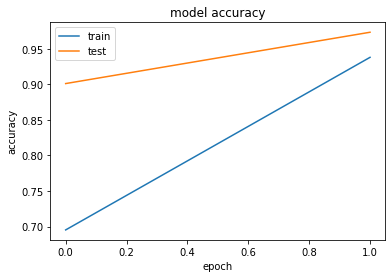

In [57]:

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss



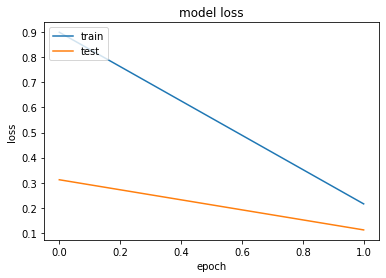

In [58]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [59]:
model_json = classifier.to_json()
with open(os.path.join("..","model","model.json"), "w") as json_file:
    json_file.write(model_json)
classifier.save_weights(os.path.join("..","model","model_weights.h5"))
print('Saved model to disk')

Saved model to disk
